In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


Initial Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB
None

Missing Values:
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

Summary Statistics:
               Age   SystolicBP  DiastolicBP           BS     BodyTemp  \
count  1014.000000  1014.000000  1014.000000  1014.000000  1014.000000   
mean     29.871795   113.198225    76.460552     8.725986    98.665089   
std      13.474386    18.403913   

/var/folders/v7/2r2hb9mj2_n5gpbv6601_8300000gn/T/ipykernel_5067/2359206173.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='RiskLevel', data=data, palette='Set2')


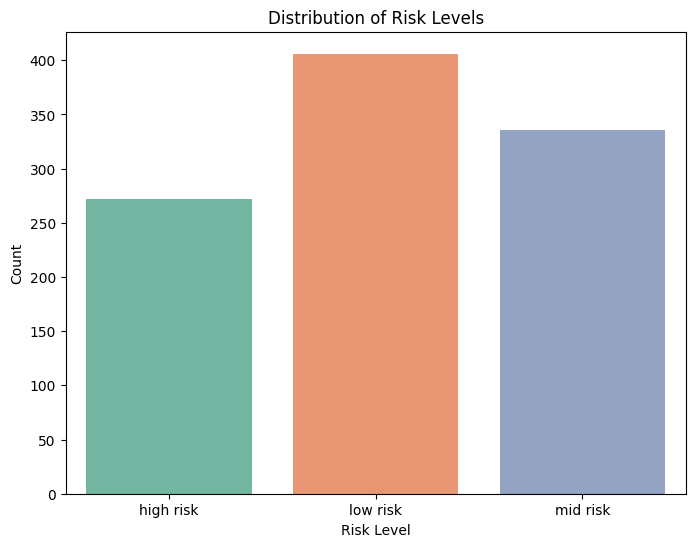

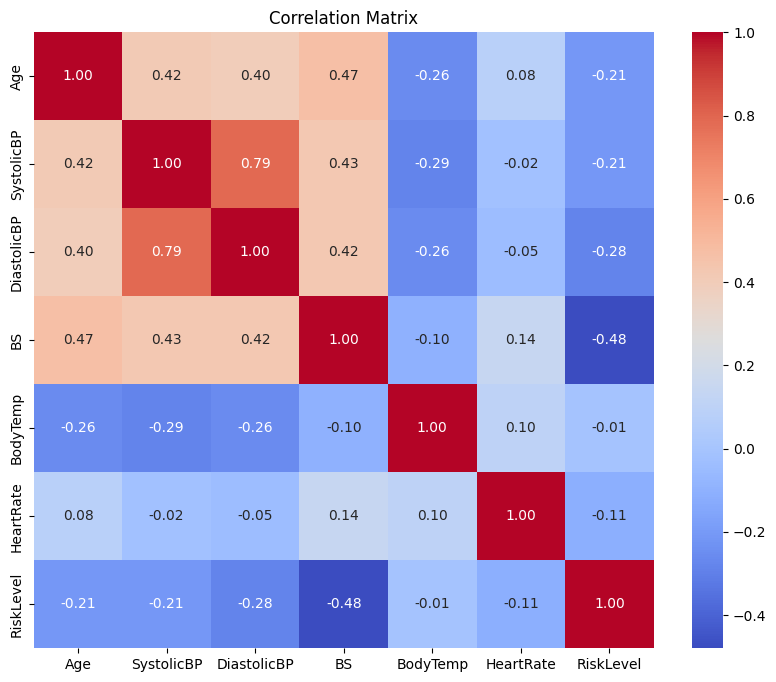

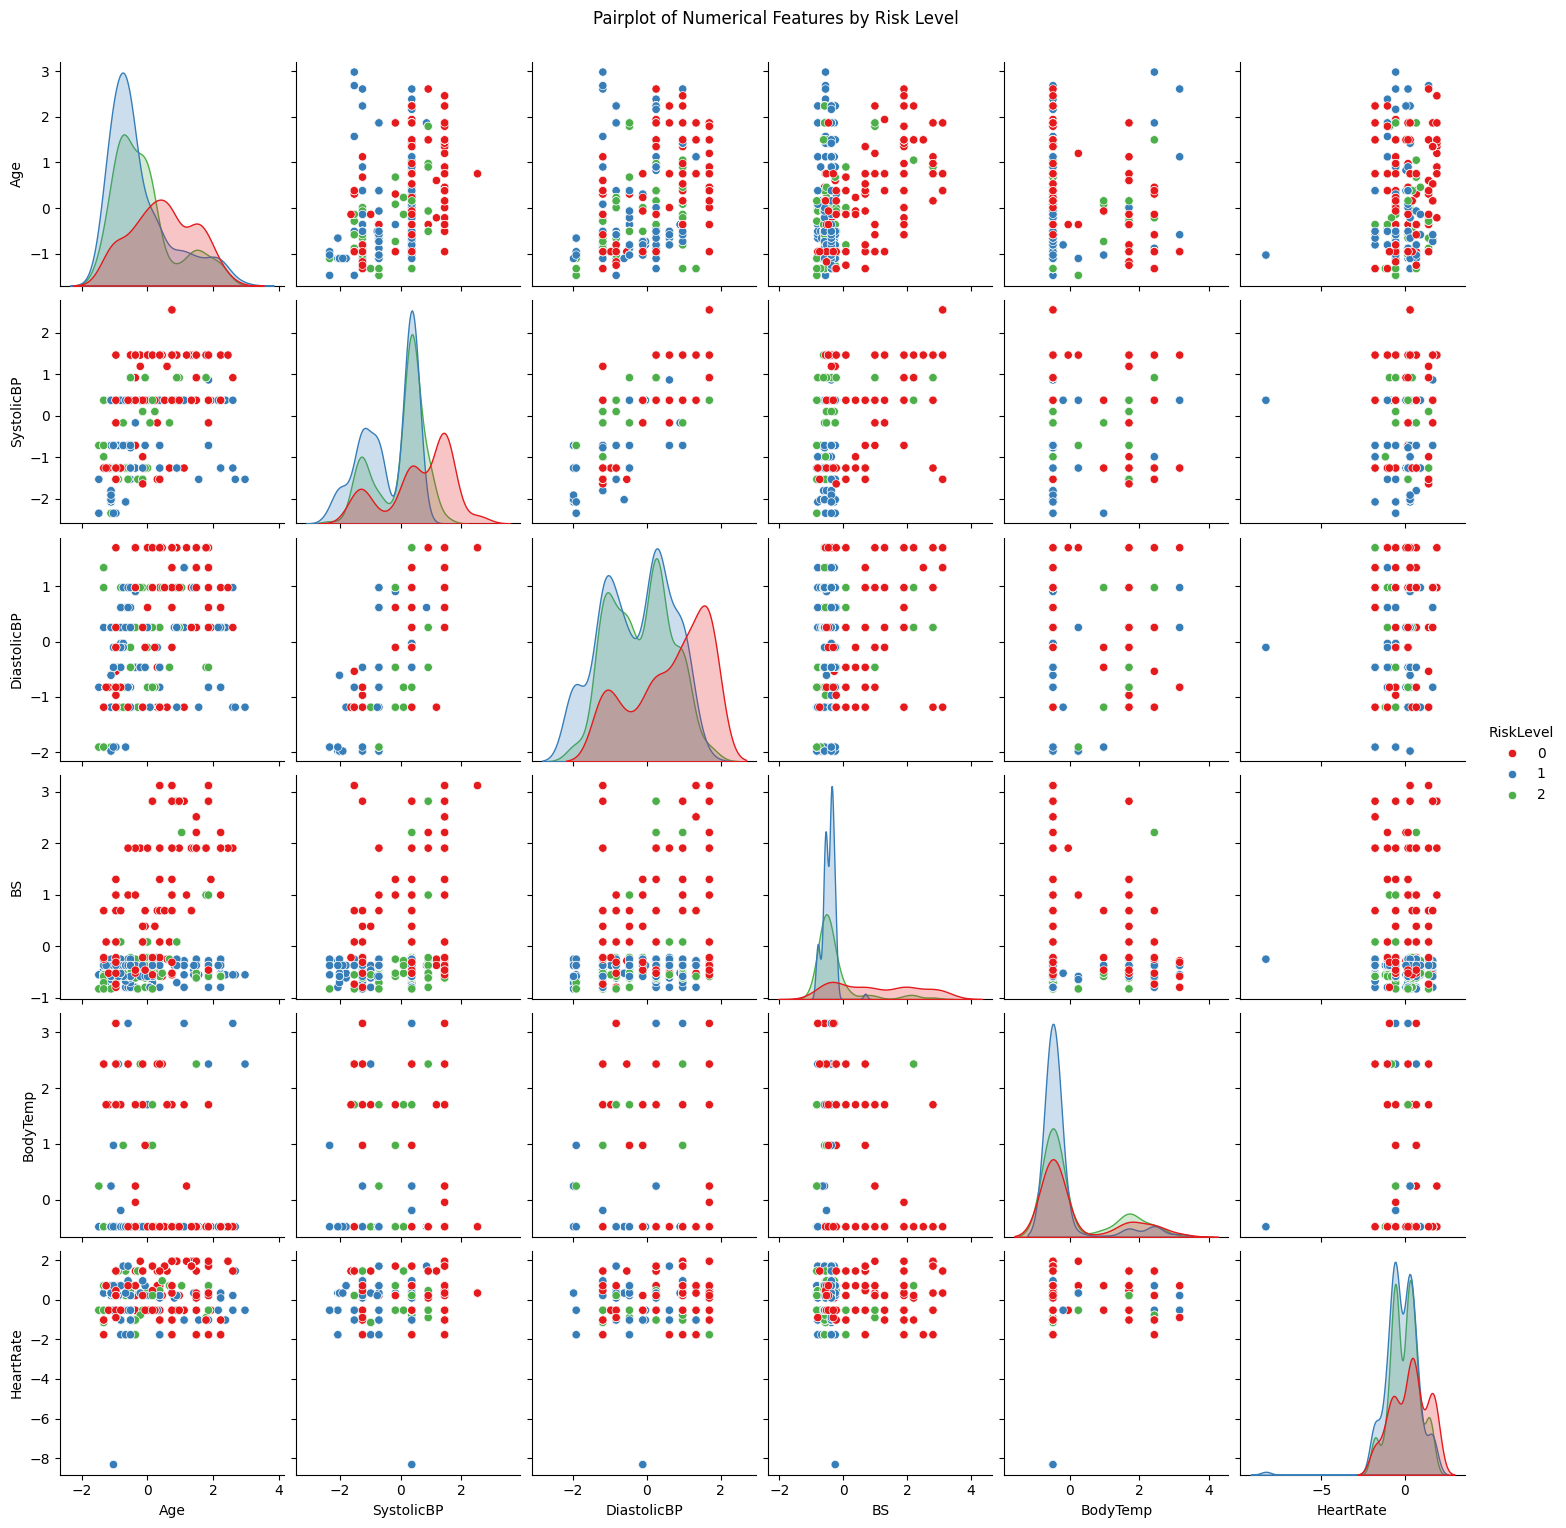

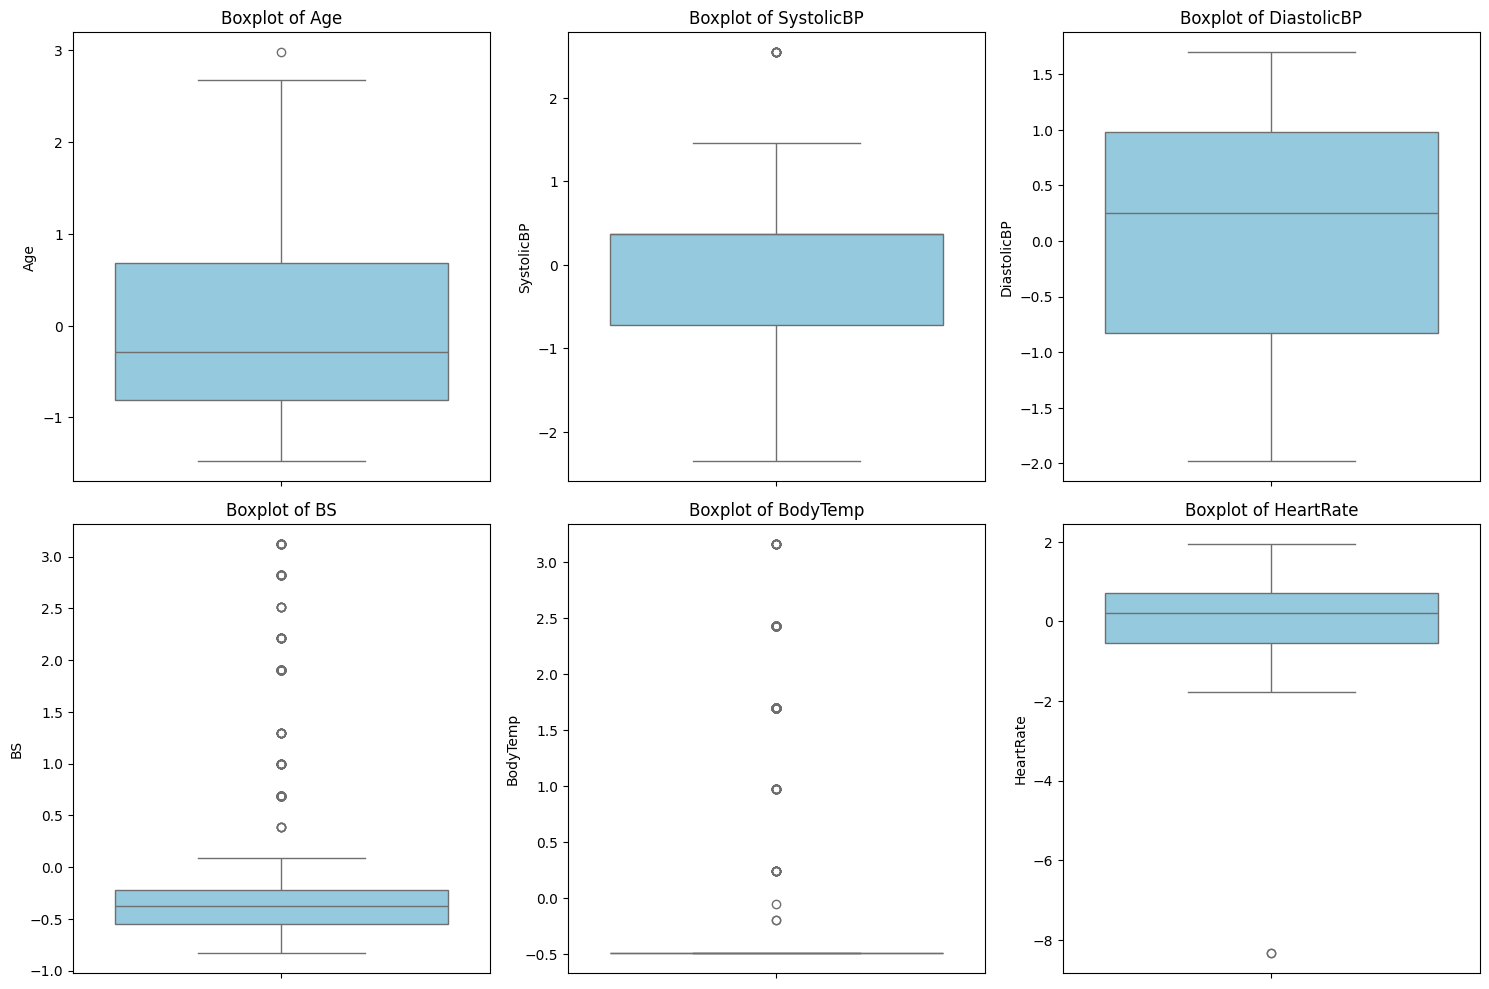


Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   float64
 1   SystolicBP   1014 non-null   float64
 2   DiastolicBP  1014 non-null   float64
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   float64
 6   RiskLevel    1014 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 55.6 KB
None


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
file_path = '/Users/narasi29/Documents/Sem 7/Machine Learning/UTS/Maternal Health Risk Data Set.csv'
data = pd.read_csv(file_path)

# Display initial dataset info
print("Initial Dataset Info:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handling missing values (if any)
# Here, we'll fill missing numerical values with median and categorical values with mode
data = data.fillna({
    col: data[col].median() if data[col].dtype in [np.float64, np.int64] else data[col].mode()[0]
    for col in data.columns
})

# Encode the target variable (if categorical)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['RiskLevel'] = label_encoder.fit_transform(data['RiskLevel'])

# Basic statistics
print("\nSummary Statistics:")
print(data.describe())

# Data preparation: Scaling numerical features
from sklearn.preprocessing import StandardScaler
numerical_features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Explanatory Data Analysis
# 1. Distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='RiskLevel', data=data, palette='Set2')
plt.title('Distribution of Risk Levels')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.xticks(ticks=range(len(label_encoder.classes_)), labels=label_encoder.classes_)
plt.show()

# 2. Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# 3. Pairplot for numerical features
sns.pairplot(data, vars=numerical_features, hue='RiskLevel', palette='Set1')
plt.suptitle('Pairplot of Numerical Features by Risk Level', y=1.02)
plt.show()

# 4. Boxplots to check for outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[col], color='skyblue')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Final cleaned dataset info
print("\nCleaned Dataset Info:")
print(data.info())


In [5]:
# Split the data
X = data.drop('RiskLevel', axis=1)
y = data['RiskLevel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define pipelines for models
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(max_iter=1000))
    ]),
    'Decision Tree': Pipeline([
        ('classifier', DecisionTreeClassifier())
    ]),
    'k-NN': Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ]),
    'XGBoost': Pipeline([
        ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'))
    ])
}

# Define hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__solver': ['lbfgs', 'liblinear']
    },
    'Decision Tree': {
        'classifier__max_depth': [None, 5, 10, 20],
        'classifier__min_samples_split': [2, 5, 10]
    },
    'k-NN': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance']
    },
    'XGBoost': {
        'classifier__n_estimators': [50, 100, 150],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__max_depth': [3, 5, 7]
    }
}

# Perform hyperparameter tuning and evaluate
results = {}
for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    
    results[model_name] = {
        'Best Parameters': best_params,
        'Accuracy': accuracy,
        'Classification Report': report
    }

# Display results
print(results)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [19:59:48] WARNING: /Users/runner/work/xgboost/xgboost/src

{'Logistic Regression': {'Best Parameters': {'classifier__C': 0.1, 'classifier__solver': 'liblinear'}, 'Accuracy': 0.6798029556650246, 'Classification Report': '              precision    recall  f1-score   support\n\n   high risk       0.86      0.78      0.82        55\n    low risk       0.61      0.90      0.73        81\n    mid risk       0.65      0.33      0.44        67\n\n    accuracy                           0.68       203\n   macro avg       0.71      0.67      0.66       203\nweighted avg       0.69      0.68      0.66       203\n'}, 'Decision Tree': {'Best Parameters': {'classifier__max_depth': None, 'classifier__min_samples_split': 2}, 'Accuracy': 0.8472906403940886, 'Classification Report': '              precision    recall  f1-score   support\n\n   high risk       0.96      0.95      0.95        55\n    low risk       0.91      0.75      0.82        81\n    mid risk       0.72      0.88      0.79        67\n\n    accuracy                           0.85       203\n   